In [1]:
import pyro
import torch
%load_ext autoreload
%autoreload 2

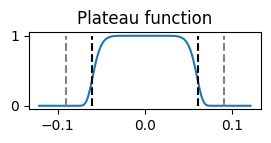

/var/folders/w_/qbzxn8q16cd8rm7svpywsynr0000gq/T/ipykernel_7012/1530881931.py:30: UserWarning: negative radius possible
  warnings.warn('negative radius possible')


tensor(0.0162)

In [10]:
# create tissue in pyro notation
import pyro.distributions as dist
import warnings
import model_utils as mutils
import data_utils as dutils
import pyro.distributions.constraints as constraints

class Prob_tissue:

    def __init__(self, tissue:dutils.Tissue_cont_indicator) -> None:
        self.tissue = tissue
        
    def compute_probs_y(self, design_params):
        
        # design 
        y_true, design = self.tissue.params2design(design_params)
        weights = design[:,0]
        design = design[:,1:3]

        # prior
        center_mu = pyro.param("center_mu", torch.tensor([0.,0.]))
        radius_mu = pyro.param("radius_mu", torch.tensor([1.]), 
                               constraint=constraints.positive)
        temp_mu = pyro.param("temp_mu", torch.tensor([1.]),
                                constraint=constraints.positive)
        center = pyro.sample("center", dist.MultivariateNormal(
            loc=center_mu, covariance_matrix=torch.eye(2)))
        radius = pyro.sample("radius", dist.Normal(radius_mu, 1.))
        temp = pyro.sample("temp", dist.Normal(temp_mu, 1.))
        warnings.warn('negative radius possible')

        # likelihood
        def g(design,center,radius,temp):
            logits = temp * (torch.norm(design-center, dim=1) - radius)
            return torch.sigmoid(-logits)
        y = pyro.sample("y", dist.Binomial(probs=g(design,center,radius,temp)))

# test
datamodule = dutils.Prostate_cancer_2d()
X,y = datamodule.get_data(processed=True)
slice_radius_pixel = 2
slice_radius = slice_radius_pixel / datamodule.norm_params['std_both']
tissue = dutils.Tissue_cont_indicator(X, y, slice_radius)
ptissue = Prob_tissue(tissue)

design_params = {
    'intercept': torch.tensor([0.]),
    'slope': torch.tensor([0.]),
}
design_params = tissue.get_initial_design_params()
tissue.params2design(design_params)
pyro.clear_param_store()
ptissue.compute_probs_y(design_params)

In [9]:
# variational inference with prior and all data observed
pyro.sample('test', lambda: 5.0 * torch.randn(1))

tensor([2.1671])

In [ ]:
# differentiable pce